## **TRAIN SEGMENTATION**

In [ ]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import neurokit2 as nk

# ----------------------------
# Paths
# ----------------------------
train_mat_dir = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\3-SPLIT_DATA\train"
labels_csv = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\3-SPLIT_DATA\train_labels.csv"

output_dir = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train"
os.makedirs(output_dir, exist_ok=True)

out_label_csv = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train_segment_labels.csv"

WINDOW_SEC = 3.0

# ----------------------------
# Load record-level labels
# ----------------------------
labels_df = pd.read_csv(labels_csv)
label_map = dict(zip(labels_df["record"], labels_df["label"]))

# ----------------------------
# Segmentation function
# ----------------------------
def segment_ecg_pcg(ecg, pcg, fs, window_sec=3.0):

    try:
        _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=fs)
        rpeaks = rpeaks["ECG_R_Peaks"]
    except Exception as e:
        # R-peak detection failed
        return []

    # If no R-peaks detected, skip
    if len(rpeaks) == 0:
        return []

    half_window = int((window_sec / 2) * fs)
    window_len = int(window_sec * fs)

    segments = []
    last_end = -1

    for r in rpeaks:
        start = r - half_window
        end = r + half_window

        if start < 0 or end > len(ecg):
            continue

        if start <= last_end:
            continue

        ecg_seg = ecg[start:end]
        pcg_seg = pcg[start:end]

        if len(ecg_seg) != window_len:
            continue

        segments.append((ecg_seg, pcg_seg))
        last_end = end

    return segments


# ----------------------------
# Dataset-wide loop
# ----------------------------
segment_labels = []
total_segments = 0

for file in os.listdir(train_mat_dir):
    if not file.endswith(".mat"):
        continue

    record_id = file.replace(".mat", "")
    mat_path = os.path.join(train_mat_dir, file)

    data = sio.loadmat(mat_path)
    ecg = data["ecg"].squeeze().astype(np.float32)
    pcg = data["pcg"].squeeze().astype(np.float32)
    fs = int(data["fs"][0][0])

    if record_id not in label_map:
        print(f"Label missing for {record_id}, skipping")
        continue

    record_label = label_map[record_id]

    segments = segment_ecg_pcg(ecg, pcg, fs, WINDOW_SEC)
    
    if len(segments) == 0:
        print(f"{record_id}: no valid R-peak segments, skipped")
        continue

    for i, (ecg_seg, pcg_seg) in enumerate(segments):
        seg_name = f"{record_id}_seg{i:03d}"

        sio.savemat(
            os.path.join(output_dir, seg_name + ".mat"),
            {
                "ecg": ecg_seg,
                "pcg": pcg_seg,
                "fs": fs,
                "record_id": record_id
            }
        )

        segment_labels.append({
            "segment_id": seg_name,
            "record_id": record_id,
            "label": record_label
        })

    total_segments += len(segments)
    print(f"{record_id}: {len(segments)} segments")

# ----------------------------
# Save segment-level labels
# ----------------------------
seg_label_df = pd.DataFrame(segment_labels)
seg_label_df.to_csv(out_label_csv, index=False)

print(f"\n✅ Total TRAIN segments: {total_segments}")
print(f"✅ Segment labels saved to: {out_label_csv}")

# -------------------------
# SEGMENTED DATA ANALYSIS
# -------------------------

# Path to segmented label file
seg_label_csv = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train_segment_labels.csv"

# Load labels
df = pd.read_csv(seg_label_csv)

# Count labels
label_counts = df["label"].value_counts()

# Percentage distribution
label_percent = df["label"].value_counts(normalize=True) * 100

print("Label counts:")
print(label_counts)

print("\nLabel percentages:")
print(label_percent)

a0001: 9 segments
a0002: 6 segments
a0004: 10 segments
a0006: 5 segments
a0007: 10 segments
a0008: 10 segments
a0010: 10 segments
a0012: 9 segments
a0013: 3 segments
a0014: 10 segments
a0015: 9 segments
a0016: 9 segments
a0017: 9 segments
a0019: 8 segments
a0020: 11 segments
a0022: 10 segments
a0023: 8 segments
a0024: 6 segments
a0025: 8 segments
a0026: 9 segments
a0027: 9 segments
a0028: 9 segments
a0029: 9 segments
a0030: 11 segments
a0031: 10 segments
a0032: 3 segments
a0033: 9 segments
a0034: 7 segments
a0035: 8 segments
a0036: 10 segments
a0037: 9 segments
a0038: 10 segments
a0039: 8 segments
a0045: 10 segments
a0046: 11 segments
a0048: 11 segments
a0049: 8 segments
a0053: 9 segments
a0054: 10 segments
a0055: 11 segments
a0056: 8 segments
a0057: 11 segments
a0058: 5 segments
a0061: 9 segments
a0064: 9 segments
a0065: 9 segments
a0067: 5 segments
a0068: 11 segments
a0069: 7 segments
a0070: 8 segments
a0072: 10 segments
a0075: 9 segments
a0076: 11 segments
a0077: no valid R-peak seg

## **TEST SEGMENTATION**

In [ ]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import neurokit2 as nk

# ----------------------------
# Paths
# ----------------------------
test_mat_dir = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\3-SPLIT_DATA\test"
labels_csv = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\3-SPLIT_DATA\test_labels.csv"

output_dir = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test"
os.makedirs(output_dir, exist_ok=True)

out_label_csv = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test_segment_labels.csv"

WINDOW_SEC = 3.0

# ----------------------------
# Load record-level labels
# ----------------------------
labels_df = pd.read_csv(labels_csv)
label_map = dict(zip(labels_df["record"], labels_df["label"]))

# ----------------------------
# Segmentation function
# ----------------------------
def segment_ecg_pcg(ecg, pcg, fs, window_sec=3.0):

    try:
        _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=fs)
        rpeaks = rpeaks["ECG_R_Peaks"]
    except Exception:
        return []

    if len(rpeaks) == 0:
        return []

    half_window = int((window_sec / 2) * fs)
    window_len = int(window_sec * fs)

    segments = []
    last_end = -1

    for r in rpeaks:
        start = r - half_window
        end = r + half_window

        if start < 0 or end > len(ecg):
            continue

        if start <= last_end:
            continue

        ecg_seg = ecg[start:end]
        pcg_seg = pcg[start:end]

        if len(ecg_seg) != window_len:
            continue

        segments.append((ecg_seg, pcg_seg))
        last_end = end

    return segments

# ----------------------------
# Dataset-wide TEST loop
# ----------------------------
segment_labels = []
total_segments = 0
skipped_records = []

for file in os.listdir(test_mat_dir):
    if not file.endswith(".mat"):
        continue

    record_id = file.replace(".mat", "")
    mat_path = os.path.join(test_mat_dir, file)

    data = sio.loadmat(mat_path)
    ecg = data["ecg"].squeeze().astype(np.float32)
    pcg = data["pcg"].squeeze().astype(np.float32)
    fs = int(data["fs"][0][0])

    if record_id not in label_map:
        print(f"Label missing for {record_id}, skipping")
        continue

    record_label = label_map[record_id]

    segments = segment_ecg_pcg(ecg, pcg, fs, WINDOW_SEC)

    if len(segments) == 0:
        print(f"{record_id}: no valid R-peak segments, skipped")
        skipped_records.append(record_id)
        continue

    for i, (ecg_seg, pcg_seg) in enumerate(segments):
        seg_name = f"{record_id}_seg{i:03d}"

        sio.savemat(
            os.path.join(output_dir, seg_name + ".mat"),
            {
                "ecg": ecg_seg,
                "pcg": pcg_seg,
                "fs": fs,
                "record_id": record_id
            }
        )

        segment_labels.append({
            "segment_id": seg_name,
            "record_id": record_id,
            "label": record_label
        })

    total_segments += len(segments)
    print(f"{record_id}: {len(segments)} segments")

# ----------------------------
# Save segment-level labels
# ----------------------------
seg_label_df = pd.DataFrame(segment_labels)
seg_label_df.to_csv(out_label_csv, index=False)

print(f"\n✅ Total TEST segments: {total_segments}")
print(f"✅ Segment labels saved to: {out_label_csv}")

if skipped_records:
    print("\nSkipped TEST records due to R-peak detection failure:")
    print(", ".join(skipped_records))

# ----------------------------
# SEGMENTED DATA ANALYSIS (TEST)
# ----------------------------
df = pd.read_csv(out_label_csv)

label_counts = df["label"].value_counts()
label_percent = df["label"].value_counts(normalize=True) * 100

print("\nLabel counts (TEST):")
print(label_counts)

print("\nLabel percentages (TEST):")
print(label_percent)


a0003: 8 segments
a0005: 10 segments
a0009: 10 segments
a0011: 10 segments
a0018: 5 segments
a0021: 10 segments
a0040: 9 segments
a0042: 10 segments
a0043: 10 segments
a0044: 8 segments
a0047: 4 segments
a0050: 8 segments
a0051: 10 segments
a0052: 10 segments
a0059: 10 segments
a0060: 9 segments
a0062: 4 segments
a0063: 9 segments
a0066: 10 segments
a0071: 9 segments
a0073: 1 segments
a0074: 11 segments
a0080: 8 segments
a0083: 9 segments
a0085: 8 segments
a0089: 6 segments
a0090: 2 segments
a0096: 10 segments
a0101: no valid R-peak segments, skipped
a0102: 6 segments
a0108: 9 segments
a0110: 10 segments
a0121: 11 segments
a0123: 6 segments
a0129: 10 segments
a0132: 7 segments
a0137: no valid R-peak segments, skipped
a0141: 9 segments
a0143: 10 segments
a0145: 9 segments
a0147: 10 segments
a0152: 9 segments
a0164: 11 segments
a0167: 10 segments
a0170: 7 segments
a0178: 10 segments
a0180: 10 segments
a0182: 10 segments
a0184: 10 segments
a0185: 10 segments
a0186: 10 segments
a0190: 10 s

## **VISUALIZATION**


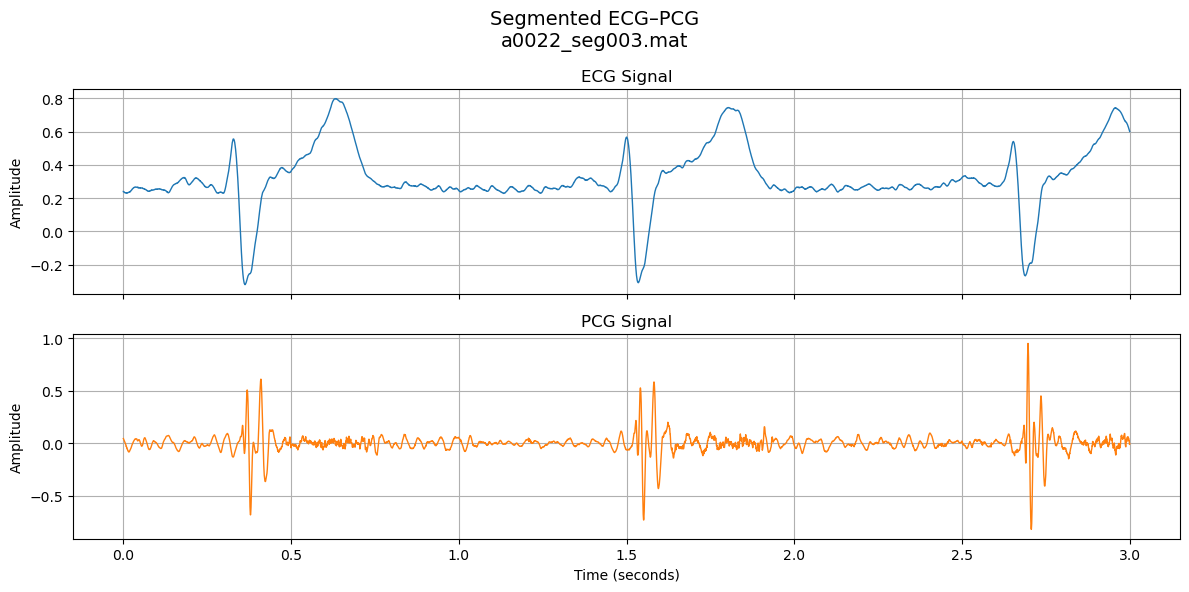

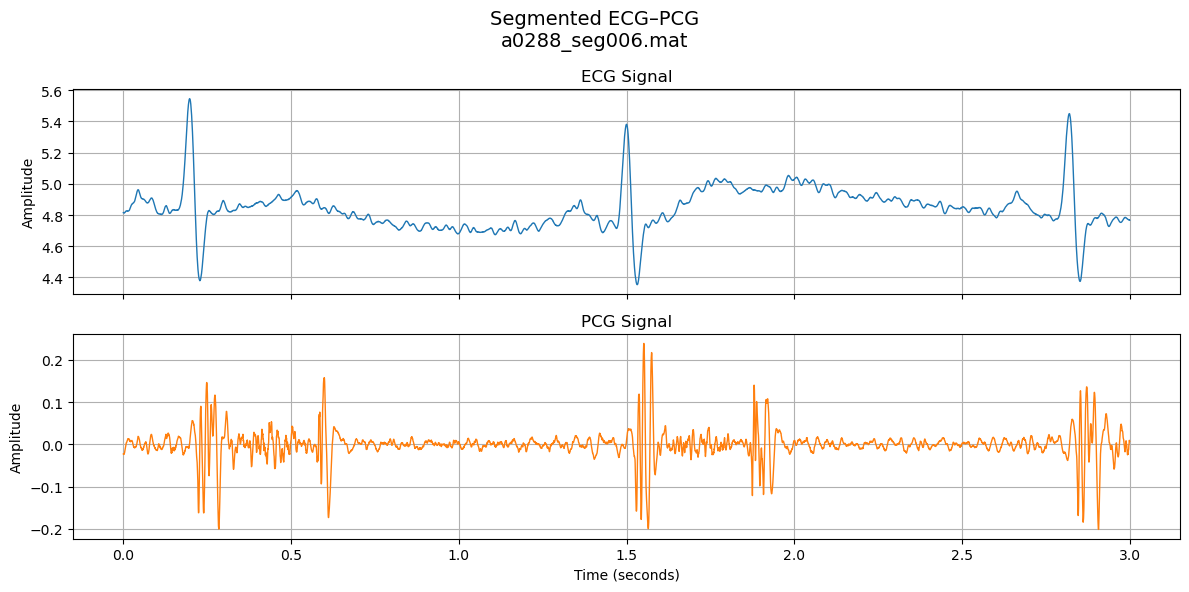

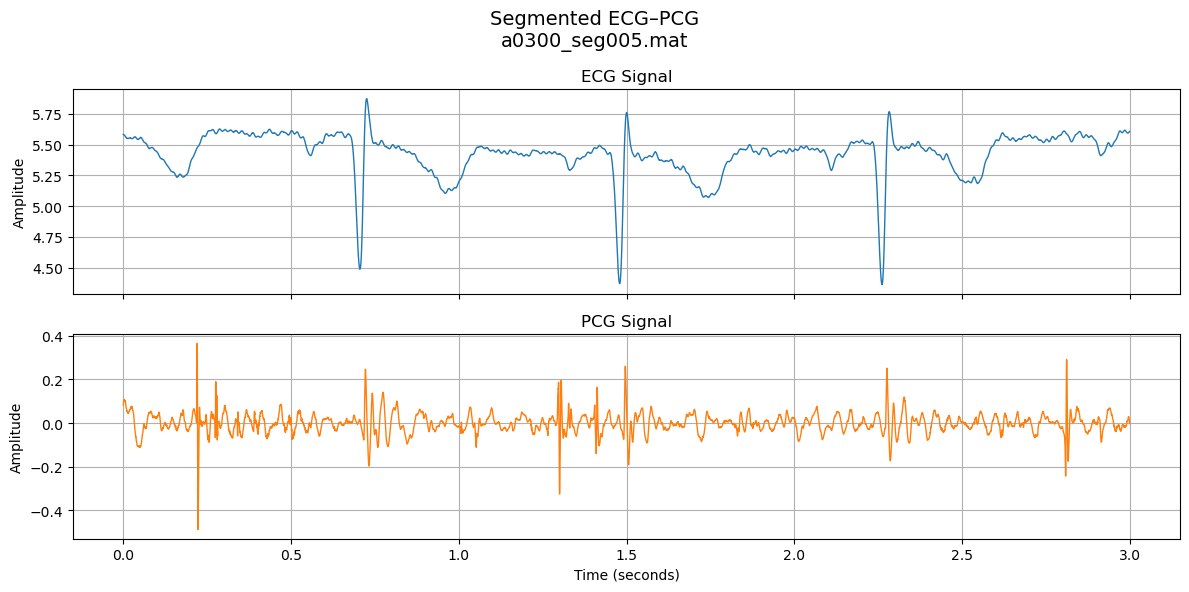

In [3]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random

def visualize_segment(mat_file_path):
    """
    Visualize ECG and PCG signals from a segmented .mat file
    """
    data = sio.loadmat(mat_file_path)

    ecg = data['ecg'].squeeze()
    pcg = data['pcg'].squeeze()
    fs = int(data['fs'].squeeze())

    duration = len(ecg) / fs
    time = np.linspace(0, duration, len(ecg))

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # ECG
    axes[0].plot(time, ecg, color='tab:blue', linewidth=1)
    axes[0].set_title('ECG Signal')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True)

    # PCG
    axes[1].plot(time, pcg, color='tab:orange', linewidth=1)
    axes[1].set_title('PCG Signal')
    axes[1].set_ylabel('Amplitude')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].grid(True)

    plt.suptitle(f'Segmented ECG–PCG\n{Path(mat_file_path).name}', fontsize=14)
    plt.tight_layout()
    plt.show()

def visualize_random_segments(segment_dir, n_samples=3):
    mat_files = list(Path(segment_dir).glob("*.mat"))
    selected = random.sample(mat_files, n_samples)

    for mat_file in selected:
        visualize_segment(mat_file)

segment_dir=r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train"
visualize_random_segments(segment_dir, n_samples=3)

## **Interpretation: Segmented ECG–PCG Signals**

The figure(s) show representative examples of segmented ECG and PCG signals extracted using an R-peak–centered windowing strategy with a fixed duration of 3 seconds. Each segment contains multiple cardiac cycles, enabling simultaneous analysis of electrical and acoustic cardiac activity.

### ECG Signal Characteristics
The segmented ECG signals exhibit clearly identifiable QRS complexes with consistent morphology across cardiac cycles. In several segments, a baseline offset is observed; however, this does not affect the preservation of waveform structure or peak localization. The presence of sharp R-peaks near the center of each segment confirms the correctness of the R-peak–centered segmentation approach. No signal clipping, flatlines, or NaN-dominated regions are observed in the displayed segments.

### PCG Signal Characteristics
The corresponding PCG segments display distinct burst-like oscillations aligned with the cardiac cycle, consistent with the timing of heart sound components (S1 and S2). Background noise levels remain low and stationary, and the acoustic energy is well localized in time. Variations in PCG amplitude across segments reflect realistic inter-recording variability and sensor placement differences rather than preprocessing artifacts.

### ECG–PCG Synchrony
Temporal alignment between ECG and PCG signals is preserved across all displayed segments, with PCG acoustic events occurring shortly after ECG R-peaks. This confirms correct synchronization between modalities and validates the integrity of the paired ECG–PCG segmentation process.

### Overall Assessment
Visual inspection of multiple segmented ECG–PCG examples confirms:
- Preservation of physiological ECG morphology and heart sound patterns
- Correct R-peak–centered segmentation
- Stable signal quality without corruption or discontinuities
- Consistent temporal synchrony between ECG and PCG modalities

These observations indicate that the segmentation procedure produces high-quality, physiologically meaningful signal segments suitable for subsequent time–frequency transformation and deep learning–based analysis.


### **Checking for NAN data**

#### TRAIN

In [8]:
import os
import scipy.io as sio
import numpy as np

# ------------------------------------------------
# Path to segmented or augmented .mat files
# ------------------------------------------------
DATA_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train"

nan_ecg = []
nan_pcg = []
nan_both = []

total_files = 0

# ------------------------------------------------
# Loop through dataset
# ------------------------------------------------
for file in os.listdir(DATA_DIR):
    if not file.endswith(".mat"):
        continue

    total_files += 1
    path = os.path.join(DATA_DIR, file)
    data = sio.loadmat(path)

    ecg = data["ecg"].squeeze()
    pcg = data["pcg"].squeeze()

    ecg_nan_ratio = np.isnan(ecg).sum() / len(ecg)
    pcg_nan_ratio = np.isnan(pcg).sum() / len(pcg)

    ecg_invalid = ecg_nan_ratio > 0.9
    pcg_invalid = pcg_nan_ratio > 0.9

    if ecg_invalid and pcg_invalid:
        nan_both.append(file)
    elif ecg_invalid:
        nan_ecg.append(file)
    elif pcg_invalid:
        nan_pcg.append(file)

# ------------------------------------------------
# Summary
# ------------------------------------------------
print(f"\nTotal segments checked: {total_files}")

print(f"\nECG invalid (>90% NaNs): {len(nan_ecg)}")
for f in nan_ecg:
    print("  ", f)

print(f"\nPCG invalid (>90% NaNs): {len(nan_pcg)}")
for f in nan_pcg:
    print("  ", f)

print(f"\nBoth ECG & PCG invalid: {len(nan_both)}")
for f in nan_both:
    print("  ", f)



Total segments checked: 2271

ECG invalid (>90% NaNs): 0

PCG invalid (>90% NaNs): 173
   a0014_seg000.mat
   a0014_seg001.mat
   a0014_seg002.mat
   a0014_seg003.mat
   a0014_seg004.mat
   a0014_seg005.mat
   a0014_seg006.mat
   a0014_seg007.mat
   a0014_seg008.mat
   a0014_seg009.mat
   a0027_seg000.mat
   a0027_seg001.mat
   a0027_seg002.mat
   a0027_seg003.mat
   a0027_seg004.mat
   a0027_seg005.mat
   a0027_seg006.mat
   a0027_seg007.mat
   a0027_seg008.mat
   a0028_seg000.mat
   a0028_seg001.mat
   a0028_seg002.mat
   a0028_seg003.mat
   a0028_seg004.mat
   a0028_seg005.mat
   a0028_seg006.mat
   a0028_seg007.mat
   a0028_seg008.mat
   a0045_seg000.mat
   a0045_seg001.mat
   a0045_seg002.mat
   a0045_seg003.mat
   a0045_seg004.mat
   a0045_seg005.mat
   a0045_seg006.mat
   a0045_seg007.mat
   a0045_seg008.mat
   a0045_seg009.mat
   a0055_seg000.mat
   a0055_seg001.mat
   a0055_seg002.mat
   a0055_seg003.mat
   a0055_seg004.mat
   a0055_seg005.mat
   a0055_seg006.mat
   a0055_seg

#### TEST

In [12]:
import os
import scipy.io as sio
import numpy as np

# ------------------------------------------------
# Path to segmented or augmented .mat files
# ------------------------------------------------
DATA_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test"

nan_ecg = []
nan_pcg = []
nan_both = []

total_files = 0

# ------------------------------------------------
# Loop through dataset
# ------------------------------------------------
for file in os.listdir(DATA_DIR):
    if not file.endswith(".mat"):
        continue

    total_files += 1
    path = os.path.join(DATA_DIR, file)
    data = sio.loadmat(path)

    ecg = data["ecg"].squeeze()
    pcg = data["pcg"].squeeze()

    ecg_nan_ratio = np.isnan(ecg).sum() / len(ecg)
    pcg_nan_ratio = np.isnan(pcg).sum() / len(pcg)

    ecg_invalid = ecg_nan_ratio > 0.9
    pcg_invalid = pcg_nan_ratio > 0.9

    if ecg_invalid and pcg_invalid:
        nan_both.append(file)
    elif ecg_invalid:
        nan_ecg.append(file)
    elif pcg_invalid:
        nan_pcg.append(file)

# ------------------------------------------------
# Summary
# ------------------------------------------------
print(f"\nTotal segments checked: {total_files}")

print(f"\nECG invalid (>90% NaNs): {len(nan_ecg)}")
for f in nan_ecg:
    print("  ", f)

print(f"\nPCG invalid (>90% NaNs): {len(nan_pcg)}")
for f in nan_pcg:
    print("  ", f)

print(f"\nBoth ECG & PCG invalid: {len(nan_both)}")
for f in nan_both:
    print("  ", f)



Total segments checked: 959

ECG invalid (>90% NaNs): 0

PCG invalid (>90% NaNs): 79
   a0018_seg000.mat
   a0018_seg001.mat
   a0018_seg002.mat
   a0018_seg003.mat
   a0018_seg004.mat
   a0185_seg000.mat
   a0185_seg001.mat
   a0185_seg002.mat
   a0185_seg003.mat
   a0185_seg004.mat
   a0185_seg005.mat
   a0185_seg006.mat
   a0185_seg007.mat
   a0185_seg008.mat
   a0185_seg009.mat
   a0204_seg000.mat
   a0204_seg001.mat
   a0204_seg002.mat
   a0204_seg003.mat
   a0204_seg004.mat
   a0204_seg005.mat
   a0204_seg006.mat
   a0204_seg007.mat
   a0204_seg008.mat
   a0261_seg000.mat
   a0261_seg001.mat
   a0261_seg002.mat
   a0261_seg003.mat
   a0261_seg004.mat
   a0261_seg005.mat
   a0261_seg006.mat
   a0261_seg007.mat
   a0261_seg008.mat
   a0261_seg009.mat
   a0311_seg000.mat
   a0311_seg001.mat
   a0311_seg002.mat
   a0311_seg003.mat
   a0311_seg004.mat
   a0311_seg005.mat
   a0311_seg006.mat
   a0311_seg007.mat
   a0314_seg000.mat
   a0314_seg001.mat
   a0314_seg002.mat
   a0314_seg00

### **Removing NAN files**

#### TRAIN

In [9]:
import os

# ------------------------------------------------
# Directory containing .mat segment files
# ------------------------------------------------

MAT_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train"

# ------------------------------------------------
# List of NaN files to remove
# ------------------------------------------------
nan_files = [
    "a0014_seg000.mat", "a0014_seg001.mat", "a0014_seg002.mat",
    "a0014_seg003.mat", "a0014_seg004.mat", "a0014_seg005.mat",
    "a0014_seg006.mat", "a0014_seg007.mat", "a0014_seg008.mat",
    "a0014_seg009.mat",

    "a0027_seg000.mat", "a0027_seg001.mat", "a0027_seg002.mat",
    "a0027_seg003.mat", "a0027_seg004.mat", "a0027_seg005.mat",
    "a0027_seg006.mat", "a0027_seg007.mat", "a0027_seg008.mat",

    "a0028_seg000.mat", "a0028_seg001.mat", "a0028_seg002.mat",
    "a0028_seg003.mat", "a0028_seg004.mat", "a0028_seg005.mat",
    "a0028_seg006.mat", "a0028_seg007.mat", "a0028_seg008.mat",

    "a0045_seg000.mat", "a0045_seg001.mat", "a0045_seg002.mat",
    "a0045_seg003.mat", "a0045_seg004.mat", "a0045_seg005.mat",
    "a0045_seg006.mat", "a0045_seg007.mat", "a0045_seg008.mat",
    "a0045_seg009.mat",

    "a0055_seg000.mat", "a0055_seg001.mat", "a0055_seg002.mat",
    "a0055_seg003.mat", "a0055_seg004.mat", "a0055_seg005.mat",
    "a0055_seg006.mat", "a0055_seg007.mat", "a0055_seg008.mat",
    "a0055_seg009.mat", "a0055_seg010.mat",

    "a0057_seg000.mat", "a0057_seg001.mat", "a0057_seg002.mat",
    "a0057_seg003.mat", "a0057_seg004.mat", "a0057_seg005.mat",
    "a0057_seg006.mat", "a0057_seg007.mat", "a0057_seg008.mat",
    "a0057_seg009.mat", "a0057_seg010.mat",

    "a0068_seg000.mat", "a0068_seg001.mat", "a0068_seg002.mat",
    "a0068_seg003.mat", "a0068_seg004.mat", "a0068_seg005.mat",
    "a0068_seg006.mat", "a0068_seg007.mat", "a0068_seg008.mat",
    "a0068_seg009.mat", "a0068_seg010.mat",

    "a0070_seg000.mat", "a0070_seg001.mat", "a0070_seg002.mat",
    "a0070_seg003.mat", "a0070_seg004.mat", "a0070_seg005.mat",
    "a0070_seg006.mat", "a0070_seg007.mat",

    "a0075_seg000.mat", "a0075_seg001.mat", "a0075_seg002.mat",
    "a0075_seg003.mat", "a0075_seg004.mat", "a0075_seg005.mat",
    "a0075_seg006.mat", "a0075_seg007.mat", "a0075_seg008.mat",

    "a0118_seg000.mat", "a0118_seg001.mat", "a0118_seg002.mat",
    "a0118_seg003.mat", "a0118_seg004.mat", "a0118_seg005.mat",
    "a0118_seg006.mat", "a0118_seg007.mat", "a0118_seg008.mat",

    "a0160_seg000.mat", "a0160_seg001.mat", "a0160_seg002.mat",
    "a0160_seg003.mat", "a0160_seg004.mat", "a0160_seg005.mat",
    "a0160_seg006.mat", "a0160_seg007.mat", "a0160_seg008.mat",
    "a0160_seg009.mat",

    "a0163_seg000.mat", "a0163_seg001.mat", "a0163_seg002.mat",
    "a0163_seg003.mat", "a0163_seg004.mat", "a0163_seg005.mat",
    "a0163_seg006.mat", "a0163_seg007.mat", "a0163_seg008.mat",

    "a0179_seg000.mat", "a0179_seg001.mat", "a0179_seg002.mat",
    "a0179_seg003.mat", "a0179_seg004.mat", "a0179_seg005.mat",
    "a0179_seg006.mat", "a0179_seg007.mat", "a0179_seg008.mat",

    "a0250_seg000.mat", "a0250_seg001.mat", "a0250_seg002.mat",
    "a0250_seg003.mat", "a0250_seg004.mat", "a0250_seg005.mat",
    "a0250_seg006.mat", "a0250_seg007.mat", "a0250_seg008.mat",

    "a0274_seg000.mat", "a0274_seg001.mat", "a0274_seg002.mat",
    "a0274_seg003.mat", "a0274_seg004.mat", "a0274_seg005.mat",
    "a0274_seg006.mat", "a0274_seg007.mat", "a0274_seg008.mat",
    "a0274_seg009.mat", "a0274_seg010.mat",

    "a0303_seg000.mat", "a0303_seg001.mat", "a0303_seg002.mat",
    "a0303_seg003.mat", "a0303_seg004.mat", "a0303_seg005.mat",
    "a0303_seg006.mat", "a0303_seg007.mat", "a0303_seg008.mat",
    "a0303_seg009.mat",

    "a0315_seg000.mat", "a0315_seg001.mat", "a0315_seg002.mat",
    "a0315_seg003.mat", "a0315_seg004.mat", "a0315_seg005.mat",

    "a0361_seg000.mat", "a0361_seg001.mat", "a0361_seg002.mat",
    "a0361_seg003.mat", "a0361_seg004.mat", "a0361_seg005.mat",
    "a0361_seg006.mat", "a0361_seg007.mat",

    "a0395_seg000.mat", "a0395_seg001.mat",
    "a0395_seg002.mat", "a0395_seg003.mat"
]

# ------------------------------------------------
# Remove files
# ------------------------------------------------
removed = 0
missing = 0

for fname in nan_files:
    path = os.path.join(MAT_DIR, fname)
    if os.path.exists(path):
        os.remove(path)
        removed += 1
        print(f"Removed: {fname}")
    else:
        missing += 1
        print(f"Missing (already removed?): {fname}")

print("\nCleanup complete")
print(f"Files removed: {removed}")
print(f"Files missing: {missing}")


Removed: a0014_seg000.mat
Removed: a0014_seg001.mat
Removed: a0014_seg002.mat
Removed: a0014_seg003.mat
Removed: a0014_seg004.mat
Removed: a0014_seg005.mat
Removed: a0014_seg006.mat
Removed: a0014_seg007.mat
Removed: a0014_seg008.mat
Removed: a0014_seg009.mat
Removed: a0027_seg000.mat
Removed: a0027_seg001.mat
Removed: a0027_seg002.mat
Removed: a0027_seg003.mat
Removed: a0027_seg004.mat
Removed: a0027_seg005.mat
Removed: a0027_seg006.mat
Removed: a0027_seg007.mat
Removed: a0027_seg008.mat
Removed: a0028_seg000.mat
Removed: a0028_seg001.mat
Removed: a0028_seg002.mat
Removed: a0028_seg003.mat
Removed: a0028_seg004.mat
Removed: a0028_seg005.mat
Removed: a0028_seg006.mat
Removed: a0028_seg007.mat
Removed: a0028_seg008.mat
Removed: a0045_seg000.mat
Removed: a0045_seg001.mat
Removed: a0045_seg002.mat
Removed: a0045_seg003.mat
Removed: a0045_seg004.mat
Removed: a0045_seg005.mat
Removed: a0045_seg006.mat
Removed: a0045_seg007.mat
Removed: a0045_seg008.mat
Removed: a0045_seg009.mat
Removed: a00

#### TEST

In [14]:
import os

# ------------------------------------------------
# Directory containing .mat segment files
# ------------------------------------------------

MAT_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test"

# ------------------------------------------------
# List of NaN files to remove
# ------------------------------------------------
nan_files  = [
    "a0018_seg000.mat",
    "a0018_seg001.mat",
    "a0018_seg002.mat",
    "a0018_seg003.mat",
    "a0018_seg004.mat",
    "a0185_seg000.mat",
    "a0185_seg001.mat",
    "a0185_seg002.mat",
    "a0185_seg003.mat",
    "a0185_seg004.mat",
    "a0185_seg005.mat",
    "a0185_seg006.mat",
    "a0185_seg007.mat",
    "a0185_seg008.mat",
    "a0185_seg009.mat",
    "a0204_seg000.mat",
    "a0204_seg001.mat",
    "a0204_seg002.mat",
    "a0204_seg003.mat",
    "a0204_seg004.mat",
    "a0204_seg005.mat",
    "a0204_seg006.mat",
    "a0204_seg007.mat",
    "a0204_seg008.mat",
    "a0261_seg000.mat",
    "a0261_seg001.mat",
    "a0261_seg002.mat",
    "a0261_seg003.mat",
    "a0261_seg004.mat",
    "a0261_seg005.mat",
    "a0261_seg006.mat",
    "a0261_seg007.mat",
    "a0261_seg008.mat",
    "a0261_seg009.mat",
    "a0311_seg000.mat",
    "a0311_seg001.mat",
    "a0311_seg002.mat",
    "a0311_seg003.mat",
    "a0311_seg004.mat",
    "a0311_seg005.mat",
    "a0311_seg006.mat",
    "a0311_seg007.mat",
    "a0314_seg000.mat",
    "a0314_seg001.mat",
    "a0314_seg002.mat",
    "a0314_seg003.mat",
    "a0314_seg004.mat",
    "a0314_seg005.mat",
    "a0320_seg000.mat",
    "a0320_seg001.mat",
    "a0320_seg002.mat",
    "a0320_seg003.mat",
    "a0320_seg004.mat",
    "a0320_seg005.mat",
    "a0320_seg006.mat",
    "a0320_seg007.mat",
    "a0320_seg008.mat",
    "a0320_seg009.mat",
    "a0320_seg010.mat",
    "a0337_seg000.mat",
    "a0337_seg001.mat",
    "a0337_seg002.mat",
    "a0337_seg003.mat",
    "a0337_seg004.mat",
    "a0337_seg005.mat",
    "a0337_seg006.mat",
    "a0337_seg007.mat",
    "a0337_seg008.mat",
    "a0347_seg000.mat",
    "a0347_seg001.mat",
    "a0347_seg002.mat",
    "a0347_seg003.mat",
    "a0347_seg004.mat",
    "a0347_seg005.mat",
    "a0400_seg000.mat",
    "a0400_seg001.mat",
    "a0400_seg002.mat",
    "a0400_seg003.mat",
    "a0400_seg004.mat"
]
# ------------------------------------------------
# Remove files
# ------------------------------------------------
removed = 0
missing = 0

for fname in nan_files:
    path = os.path.join(MAT_DIR, fname)
    if os.path.exists(path):
        os.remove(path)
        removed += 1
        print(f"Removed: {fname}")
    else:
        missing += 1
        print(f"Missing (already removed?): {fname}")

print("\nCleanup complete")
print(f"Files removed: {removed}")
print(f"Files missing: {missing}")


Removed: a0018_seg000.mat
Removed: a0018_seg001.mat
Removed: a0018_seg002.mat
Removed: a0018_seg003.mat
Removed: a0018_seg004.mat
Removed: a0185_seg000.mat
Removed: a0185_seg001.mat
Removed: a0185_seg002.mat
Removed: a0185_seg003.mat
Removed: a0185_seg004.mat
Removed: a0185_seg005.mat
Removed: a0185_seg006.mat
Removed: a0185_seg007.mat
Removed: a0185_seg008.mat
Removed: a0185_seg009.mat
Removed: a0204_seg000.mat
Removed: a0204_seg001.mat
Removed: a0204_seg002.mat
Removed: a0204_seg003.mat
Removed: a0204_seg004.mat
Removed: a0204_seg005.mat
Removed: a0204_seg006.mat
Removed: a0204_seg007.mat
Removed: a0204_seg008.mat
Removed: a0261_seg000.mat
Removed: a0261_seg001.mat
Removed: a0261_seg002.mat
Removed: a0261_seg003.mat
Removed: a0261_seg004.mat
Removed: a0261_seg005.mat
Removed: a0261_seg006.mat
Removed: a0261_seg007.mat
Removed: a0261_seg008.mat
Removed: a0261_seg009.mat
Removed: a0311_seg000.mat
Removed: a0311_seg001.mat
Removed: a0311_seg002.mat
Removed: a0311_seg003.mat
Removed: a03

### **Verifying Removal**

##### TRAIN

In [ ]:
import os
import scipy.io as sio
import numpy as np

# ------------------------------------------------
# Path to segmented or augmented .mat files
# ------------------------------------------------
DATA_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train"

nan_ecg = []
nan_pcg = []
nan_both = []

total_files = 0

# ------------------------------------------------
# Loop through dataset
# ------------------------------------------------
for file in os.listdir(DATA_DIR):
    if not file.endswith(".mat"):
        continue

    total_files += 1
    path = os.path.join(DATA_DIR, file)
    data = sio.loadmat(path)

    ecg = data["ecg"].squeeze()
    pcg = data["pcg"].squeeze()

    ecg_nan_ratio = np.isnan(ecg).sum() / len(ecg)
    pcg_nan_ratio = np.isnan(pcg).sum() / len(pcg)

    ecg_invalid = ecg_nan_ratio > 0.9
    pcg_invalid = pcg_nan_ratio > 0.9

    if ecg_invalid and pcg_invalid:
        nan_both.append(file)
    elif ecg_invalid:
        nan_ecg.append(file)
    elif pcg_invalid:
        nan_pcg.append(file)

# ------------------------------------------------
# Summary
# ------------------------------------------------
print(f"\nTotal segments checked: {total_files}")

print(f"\nECG invalid (>90% NaNs): {len(nan_ecg)}")
for f in nan_ecg:
    print("  ", f)

print(f"\nPCG invalid (>90% NaNs): {len(nan_pcg)}")
for f in nan_pcg:
    print("  ", f)

print(f"\nBoth ECG & PCG invalid: {len(nan_both)}")
for f in nan_both:
    print("  ", f)



Total segments checked: 2098

ECG invalid (>90% NaNs): 0

PCG invalid (>90% NaNs): 0

Both ECG & PCG invalid: 0


#### TEST

In [15]:
import os
import scipy.io as sio
import numpy as np

# ------------------------------------------------
# Path to segmented or augmented .mat files
# ------------------------------------------------
DATA_DIR = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test"

nan_ecg = []
nan_pcg = []
nan_both = []

total_files = 0

# ------------------------------------------------
# Loop through dataset
# ------------------------------------------------
for file in os.listdir(DATA_DIR):
    if not file.endswith(".mat"):
        continue

    total_files += 1
    path = os.path.join(DATA_DIR, file)
    data = sio.loadmat(path)

    ecg = data["ecg"].squeeze()
    pcg = data["pcg"].squeeze()

    ecg_nan_ratio = np.isnan(ecg).sum() / len(ecg)
    pcg_nan_ratio = np.isnan(pcg).sum() / len(pcg)

    ecg_invalid = ecg_nan_ratio > 0.9
    pcg_invalid = pcg_nan_ratio > 0.9

    if ecg_invalid and pcg_invalid:
        nan_both.append(file)
    elif ecg_invalid:
        nan_ecg.append(file)
    elif pcg_invalid:
        nan_pcg.append(file)

# ------------------------------------------------
# Summary
# ------------------------------------------------
print(f"\nTotal segments checked: {total_files}")

print(f"\nECG invalid (>90% NaNs): {len(nan_ecg)}")
for f in nan_ecg:
    print("  ", f)

print(f"\nPCG invalid (>90% NaNs): {len(nan_pcg)}")
for f in nan_pcg:
    print("  ", f)

print(f"\nBoth ECG & PCG invalid: {len(nan_both)}")
for f in nan_both:
    print("  ", f)



Total segments checked: 880

ECG invalid (>90% NaNs): 0

PCG invalid (>90% NaNs): 0

Both ECG & PCG invalid: 0


### **Cleaning Labels**

#### TRAIN

In [16]:
import pandas as pd

# ------------------------------------------------
# Paths
# ------------------------------------------------
LABEL_CSV = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train_segment_labels.csv"
OUT_CSV   = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train_segment_labels_cleaned.csv"

# ------------------------------------------------
# List of removed NaN segment files (WITHOUT .mat)
# ------------------------------------------------
nan_segments = [
    "a0014_seg000", "a0014_seg001", "a0014_seg002", "a0014_seg003",
    "a0014_seg004", "a0014_seg005", "a0014_seg006", "a0014_seg007",
    "a0014_seg008", "a0014_seg009",

    "a0027_seg000", "a0027_seg001", "a0027_seg002", "a0027_seg003",
    "a0027_seg004", "a0027_seg005", "a0027_seg006", "a0027_seg007",
    "a0027_seg008",

    "a0028_seg000", "a0028_seg001", "a0028_seg002", "a0028_seg003",
    "a0028_seg004", "a0028_seg005", "a0028_seg006", "a0028_seg007",
    "a0028_seg008",

    "a0045_seg000", "a0045_seg001", "a0045_seg002", "a0045_seg003",
    "a0045_seg004", "a0045_seg005", "a0045_seg006", "a0045_seg007",
    "a0045_seg008", "a0045_seg009",

    "a0055_seg000", "a0055_seg001", "a0055_seg002", "a0055_seg003",
    "a0055_seg004", "a0055_seg005", "a0055_seg006", "a0055_seg007",
    "a0055_seg008", "a0055_seg009", "a0055_seg010",

    "a0057_seg000", "a0057_seg001", "a0057_seg002", "a0057_seg003",
    "a0057_seg004", "a0057_seg005", "a0057_seg006", "a0057_seg007",
    "a0057_seg008", "a0057_seg009", "a0057_seg010",

    "a0068_seg000", "a0068_seg001", "a0068_seg002", "a0068_seg003",
    "a0068_seg004", "a0068_seg005", "a0068_seg006", "a0068_seg007",
    "a0068_seg008", "a0068_seg009", "a0068_seg010",

    "a0070_seg000", "a0070_seg001", "a0070_seg002", "a0070_seg003",
    "a0070_seg004", "a0070_seg005", "a0070_seg006", "a0070_seg007",

    "a0075_seg000", "a0075_seg001", "a0075_seg002", "a0075_seg003",
    "a0075_seg004", "a0075_seg005", "a0075_seg006", "a0075_seg007",
    "a0075_seg008",

    "a0118_seg000", "a0118_seg001", "a0118_seg002", "a0118_seg003",
    "a0118_seg004", "a0118_seg005", "a0118_seg006", "a0118_seg007",
    "a0118_seg008",

    "a0160_seg000", "a0160_seg001", "a0160_seg002", "a0160_seg003",
    "a0160_seg004", "a0160_seg005", "a0160_seg006", "a0160_seg007",
    "a0160_seg008", "a0160_seg009",

    "a0163_seg000", "a0163_seg001", "a0163_seg002", "a0163_seg003",
    "a0163_seg004", "a0163_seg005", "a0163_seg006", "a0163_seg007",
    "a0163_seg008",

    "a0179_seg000", "a0179_seg001", "a0179_seg002", "a0179_seg003",
    "a0179_seg004", "a0179_seg005", "a0179_seg006", "a0179_seg007",
    "a0179_seg008",

    "a0250_seg000", "a0250_seg001", "a0250_seg002", "a0250_seg003",
    "a0250_seg004", "a0250_seg005", "a0250_seg006", "a0250_seg007",
    "a0250_seg008",

    "a0274_seg000", "a0274_seg001", "a0274_seg002", "a0274_seg003",
    "a0274_seg004", "a0274_seg005", "a0274_seg006", "a0274_seg007",
    "a0274_seg008", "a0274_seg009", "a0274_seg010",

    "a0303_seg000", "a0303_seg001", "a0303_seg002", "a0303_seg003",
    "a0303_seg004", "a0303_seg005", "a0303_seg006", "a0303_seg007",
    "a0303_seg008", "a0303_seg009",

    "a0315_seg000", "a0315_seg001", "a0315_seg002", "a0315_seg003",
    "a0315_seg004", "a0315_seg005",

    "a0361_seg000", "a0361_seg001", "a0361_seg002", "a0361_seg003",
    "a0361_seg004", "a0361_seg005", "a0361_seg006", "a0361_seg007",

    "a0395_seg000", "a0395_seg001", "a0395_seg002", "a0395_seg003"
]

# ------------------------------------------------
# Clean label file
# ------------------------------------------------
df = pd.read_csv(LABEL_CSV)

before = len(df)
df_clean = df[~df["segment_id"].isin(nan_segments)]
after = len(df_clean)

df_clean.to_csv(OUT_CSV, index=False)

print(f"Original labels: {before}")
print(f"Removed NaN segments: {before - after}")
print(f"Clean labels saved: {after}")
print(f"Saved to: {OUT_CSV}")


Original labels: 2271
Removed NaN segments: 173
Clean labels saved: 2098
Saved to: E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\train_segment_labels_cleaned.csv


#### TEST

In [22]:
import pandas as pd

# ------------------------------------------------
# Paths
# ------------------------------------------------
LABEL_CSV = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test_segment_labels.csv"
OUT_CSV   = r"E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test_segment_labels_cleaned.csv"

# ------------------------------------------------
# List of removed NaN segment files (WITHOUT .mat)
# ------------------------------------------------
nan_segments = [
    'a0018_seg000',
    'a0018_seg001',
    'a0018_seg002',
    'a0018_seg003',
    'a0018_seg004',
    'a0185_seg000',
    'a0185_seg001',
    'a0185_seg002',
    'a0185_seg003',
    'a0185_seg004',
    'a0185_seg005',
    'a0185_seg006',
    'a0185_seg007',
    'a0185_seg008',
    'a0185_seg009',
    'a0204_seg000',
    'a0204_seg001',
    'a0204_seg002',
    'a0204_seg003',
    'a0204_seg004',
    'a0204_seg005',
    'a0204_seg006',
    'a0204_seg007',
    'a0204_seg008',
    'a0261_seg000',
    'a0261_seg001',
    'a0261_seg002',
    'a0261_seg003',
    'a0261_seg004',
    'a0261_seg005',
    'a0261_seg006',
    'a0261_seg007',
    'a0261_seg008',
    'a0261_seg009',
    'a0311_seg000',
    'a0311_seg001',
    'a0311_seg002',
    'a0311_seg003',
    'a0311_seg004',
    'a0311_seg005',
    'a0311_seg006',
    'a0311_seg007',
    'a0314_seg000',
    'a0314_seg001',
    'a0314_seg002',
    'a0314_seg003',
    'a0314_seg004',
    'a0314_seg005',
    'a0320_seg000',
    'a0320_seg001',
    'a0320_seg002',
    'a0320_seg003',
    'a0320_seg004',
    'a0320_seg005',
    'a0320_seg006',
    'a0320_seg007',
    'a0320_seg008',
    'a0320_seg009',
    'a0320_seg010',
    'a0337_seg000',
    'a0337_seg001',
    'a0337_seg002',
    'a0337_seg003',
    'a0337_seg004',
    'a0337_seg005',
    'a0337_seg006',
    'a0337_seg007',
    'a0337_seg008',
    'a0347_seg000',
    'a0347_seg001',
    'a0347_seg002',
    'a0347_seg003',
    'a0347_seg004',
    'a0347_seg005',
    'a0400_seg000',
    'a0400_seg001',
    'a0400_seg002',
    'a0400_seg003',
    'a0400_seg004'
]

# ------------------------------------------------
# Clean label file
# ------------------------------------------------
df = pd.read_csv(LABEL_CSV)

before = len(df)
df_clean = df[~df["segment_id"].isin(nan_segments)]
after = len(df_clean)

df_clean.to_csv(OUT_CSV, index=False)

print(f"Original labels: {before}")
print(f"Removed NaN segments: {before - after}")
print(f"Clean labels saved: {after}")
print(f"Saved to: {OUT_CSV}")


Original labels: 959
Removed NaN segments: 79
Clean labels saved: 880
Saved to: E:\PROJECTS\CARDIAC-PROJECT-UPDATED\DATASET\4-SEGMENTED_DATA\test_segment_labels_cleaned.csv


### **Dataset Expansion After Segmentation**

R-peak–centered segmentation was applied to convert record-level ECG–PCG data into fixed-length segments, substantially increasing the effective dataset size.

**Training set:**
- Original records: 283 patients  
- Segmented windows: 2,271 segments  
- **Expansion factor:** ~8.0× increase

**Test set:**
- Original records: 122 patients  
- Segmented windows: 959 segments  
- **Expansion factor:** ~7.9× increase

Overall, segmentation increased the number of available samples by approximately **8×**, enabling more effective training of deep learning models while preserving patient-wise separation and preventing data leakage.

All segments inherit the label of their corresponding patient record, ensuring label consistency after expansion.
